In [1]:
##Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import warnings
warnings.filterwarnings('ignore')

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

print("Libraries imported successfully!")

Libraries imported successfully!


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gungun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Gungun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Load the dataset
csv_path = "C:/Users/Gungun/Downloads/archive (2)/BBCNews.csv"
df = pd.read_csv(csv_path)

print(f" Dataset loaded! Shape: {df.shape}")
print(f" Columns: {df.columns.tolist()}")
print("\nFirst 3 rows:")
print(df.head(3))

 Dataset loaded! Shape: (2410, 3)
 Columns: ['Unnamed: 0', 'descr', 'tags']

First 3 rows:
   Unnamed: 0                                              descr  \
0           0  chelsea sack mutu  chelsea have sacked adrian ...   
1           1  record fails to lift lacklustre meet  yelena i...   
2           2  edu describes tunnel fracas  arsenals edu has ...   

                                                tags  
0  sports, stamford bridge, football association,...  
1  sports, madrid, birmingham, france, scotland, ...  
2  sports, derby, brazil, tunnel fracasedu, food,...  


In [9]:
# CELL 3: Debug Dataset Structure
print(" Dataset Info:")
print(df.info())
print(f"\n All columns: {df.columns.tolist()}")

# Show actual data structure
print(f"\n First 3 rows (all columns):")
for i in range(min(3, len(df))):
    print(f"\n--- Row {i} ---")
    for col in df.columns:
        value = df[col].iloc[i]
        if isinstance(value, str):
            print(f"  {col}: {value[:100]}...")
        else:
            print(f"  {col}: {value}")

# Check each column's properties
print(f"\n Column Analysis:")
for col in df.columns:
    unique_count = df[col].nunique()
    sample_value = df[col].iloc[0] if len(df) > 0 else "No data"
    print(f"  {col}: {unique_count} unique values, sample: {str(sample_value)[:50]}...")

 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 2408 entries, 0 to 2409
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    2408 non-null   int64 
 1   descr         2408 non-null   object
 2   tags          2408 non-null   object
 3   cleaned_text  2408 non-null   object
dtypes: int64(1), object(3)
memory usage: 94.1+ KB
None

 All columns: ['Unnamed: 0', 'descr', 'tags', 'cleaned_text']

 First 3 rows (all columns):

--- Row 0 ---
  Unnamed: 0: 0
  descr: chelsea sack mutu  chelsea have sacked adrian mutu after he failed a drugs test  the yearold tested ...
  tags: sports, stamford bridge, football association, fifa, michelle verroken, adrian mutu, jose mourinho, ...
  cleaned_text: chelsea sack mutu chelsea sacked adrian mutu failed drug test yearold tested positive banned substan...

--- Row 1 ---
  Unnamed: 0: 1
  descr: record fails to lift lacklustre meet  yelena isinbayeva may have pr

In [12]:
# Identify Columns Correctly
print(" Identifying text and category columns...")

# Strategy: Find the column with the most text (longest strings)
text_candidates = []
for col in df.columns:
    if df[col].dtype == 'object':  # String columns
        avg_length = df[col].astype(str).str.len().mean()
        text_candidates.append((col, avg_length))
        print(f"  {col}: avg length {avg_length:.1f} chars")

# Sort by average length (longest first)
text_candidates.sort(key=lambda x: x[1], reverse=True)

if text_candidates:
    text_column = text_candidates[0][0]  # Column with longest text
    print(f" Selected text column: '{text_column}' (avg length: {text_candidates[0][1]:.1f} chars)")
else:
    text_column = df.columns[0]  # Fallback to first column
    print(f" Using first column as text: '{text_column}'")

# Strategy: Find the column with few unique values (likely category)
category_candidates = []
for col in df.columns:
    unique_count = df[col].nunique()
    if unique_count < 50:  # Categories should have limited values
        category_candidates.append((col, unique_count))
        print(f"  {col}: {unique_count} unique values")

if category_candidates:
    # Sort by number of unique values (fewest first)
    category_candidates.sort(key=lambda x: x[1])
    category_column = category_candidates[0][0]
    print(f" Selected category column: '{category_column}' ({category_candidates[0][1]} unique values)")
    print(f"   Categories: {df[category_column].unique()}")
else:
    # If no obvious category, create a dummy one
    category_column = 'dummy_category'
    df[category_column] = 'general'  # All articles in one category
    print(f" Created dummy category column: '{category_column}'")

print(f"\n Final selection:")
print(f"   Text column: {text_column}")
print(f"   Category column: {category_column}")

 Identifying text and category columns...
  descr: avg length 2225.5 chars
  tags: avg length 417.2 chars
  cleaned_text: avg length 1537.2 chars
  dummy_category: avg length 7.0 chars
 Selected text column: 'descr' (avg length: 2225.5 chars)
  dummy_category: 1 unique values
 Selected category column: 'dummy_category' (1 unique values)
   Categories: ['general']

 Final selection:
   Text column: descr
   Category column: dummy_category


In [13]:
# Simple Preprocessing 
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def simple_preprocess(text):
    """Simple text preprocessing"""
    if not isinstance(text, str) or pd.isna(text):
        return ""
    
    # Basic cleaning
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

print(" Simple text preprocessing...")
df['cleaned_text'] = df[text_column].apply(simple_preprocess)

# Remove completely empty texts
initial_count = len(df)
df = df[df['cleaned_text'].str.len() > 10]  # Keep texts with more than 10 characters
print(f" Removed {initial_count - len(df)} empty texts")
print(f" Final dataset size: {len(df)}")

# Show category distribution
print(f"\n Category distribution:")
category_counts = df[category_column].value_counts()
print(category_counts)

print(f"\n Sample original text:")
sample_text = df[text_column].iloc[0] if len(df) > 0 else "No data"
print(f"{str(sample_text)[:200]}...")

print(f"\n Sample cleaned text:")
sample_cleaned = df['cleaned_text'].iloc[0] if len(df) > 0 else "No data"
print(f"{str(sample_cleaned)[:200]}...")

 Simple text preprocessing...
 Removed 0 empty texts
 Final dataset size: 2408

 Category distribution:
dummy_category
general    2408
Name: count, dtype: int64

 Sample original text:
chelsea sack mutu  chelsea have sacked adrian mutu after he failed a drugs test  the yearold tested positive for a banned substance  which he later denied was cocaine  in october chelsea have decided ...

 Sample cleaned text:
chelsea sack mutu chelsea have sacked adrian mutu after he failed a drugs test the yearold tested positive for a banned substance which he later denied was cocaine in october chelsea have decided to w...


In [14]:
# Safe Data Preparation
# Prepare features and labels
X = df['cleaned_text']
y = df[category_column]

print(f" Total samples: {len(X)}")

# If we have very few categories, create a dummy category
if y.nunique() <= 1:
    print("  Only one category found. Creating dummy categories based on text length...")
    # Create categories based on text length quartiles
    text_lengths = X.str.len()
    y = pd.cut(text_lengths, bins=4, labels=['short', 'medium', 'long', 'very_long'])
    print(f" Created categories: {y.unique()}")

# Encode categories
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\n Category mapping:")
for i, category in enumerate(label_encoder.classes_):
    count = (y == category).sum()
    print(f"  {category}: {i} ({count} samples)")

# Simple split without stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

print(f"\n Training set: {len(X_train)} samples")
print(f" Testing set: {len(X_test)} samples")
print(" Data preparation complete!")

 Total samples: 2408
  Only one category found. Creating dummy categories based on text length...
 Created categories: ['short', 'medium', 'very_long', 'long']
Categories (4, object): ['short' < 'medium' < 'long' < 'very_long']

 Category mapping:
  long: 0 (3 samples)
  medium: 1 (157 samples)
  short: 2 (2240 samples)
  very_long: 3 (8 samples)

 Training set: 1926 samples
 Testing set: 482 samples
 Data preparation complete!


In [15]:
# Feature Extraction
print(" Creating Bag of Words features...")
bow_vectorizer = CountVectorizer(max_features=2000, ngram_range=(1, 2), stop_words='english')  # Reduced features for stability
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

print(" Creating TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1, 2), stop_words='english')  # Reduced features for stability
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f" BoW shapes - Train: {X_train_bow.shape}, Test: {X_test_bow.shape}")
print(f" TF-IDF shapes - Train: {X_train_tfidf.shape}, Test: {X_test_tfidf.shape}")

 Creating Bag of Words features...
 Creating TF-IDF features...
 BoW shapes - Train: (1926, 2000), Test: (482, 2000)
 TF-IDF shapes - Train: (1926, 2000), Test: (482, 2000)


In [16]:
# Model Training and Evaluation
def train_evaluate_model(model, X_train, X_test, y_train, y_test, model_name, vectorizer_name):
    print(f"\n{'='*60}")
    print(f" {model_name} with {vectorizer_name}")
    print(f"{'='*60}")
    
    try:
        # Train model
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        
        # Accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f" Accuracy: {accuracy:.4f}")
        
        # Classification report
        print("\n Classification Report:")
        print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
        
        return accuracy, y_pred
        
    except Exception as e:
        print(f" Error: {e}")
        return 0, None

# Initialize models with simpler parameters for stability
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=500, C=1.0),
    'SVM': SVC(random_state=42, kernel='linear', C=1.0)
}

results = {}

# Train with BoW
print(" TRAINING WITH BAG OF WORDS")
print("="*50)
for model_name, model in models.items():
    accuracy, y_pred = train_evaluate_model(
        model, X_train_bow, X_test_bow, y_train, y_test, model_name, 'BoW'
    )
    if y_pred is not None:
        results[f'{model_name}_BoW'] = {'accuracy': accuracy, 'predictions': y_pred}

# Train with TF-IDF
print("\n TRAINING WITH TF-IDF")
print("="*50)
for model_name, model in models.items():
    accuracy, y_pred = train_evaluate_model(
        model, X_train_tfidf, X_test_tfidf, y_train, y_test, model_name, 'TF-IDF'
    )
    if y_pred is not None:
        results[f'{model_name}_TF-IDF'] = {'accuracy': accuracy, 'predictions': y_pred}

print(" Model training completed!")

 TRAINING WITH BAG OF WORDS

 Logistic Regression with BoW
 Accuracy: 0.9564

 Classification Report:
              precision    recall  f1-score   support

        long       0.00      0.00      0.00         2
      medium       0.75      0.50      0.60        30
       short       0.97      0.99      0.98       450
   very_long       0.00      0.00      0.00         0

    accuracy                           0.96       482
   macro avg       0.43      0.37      0.39       482
weighted avg       0.95      0.96      0.95       482


 SVM with BoW
 Accuracy: 0.9606

 Classification Report:
 Error: Number of classes, 3, does not match size of target_names, 4. Try specifying the labels parameter

 TRAINING WITH TF-IDF

 Logistic Regression with TF-IDF
 Accuracy: 0.9419

 Classification Report:
 Error: Number of classes, 3, does not match size of target_names, 4. Try specifying the labels parameter

 SVM with TF-IDF
 Accuracy: 0.9544

 Classification Report:
 Error: Number of classes, 3, do

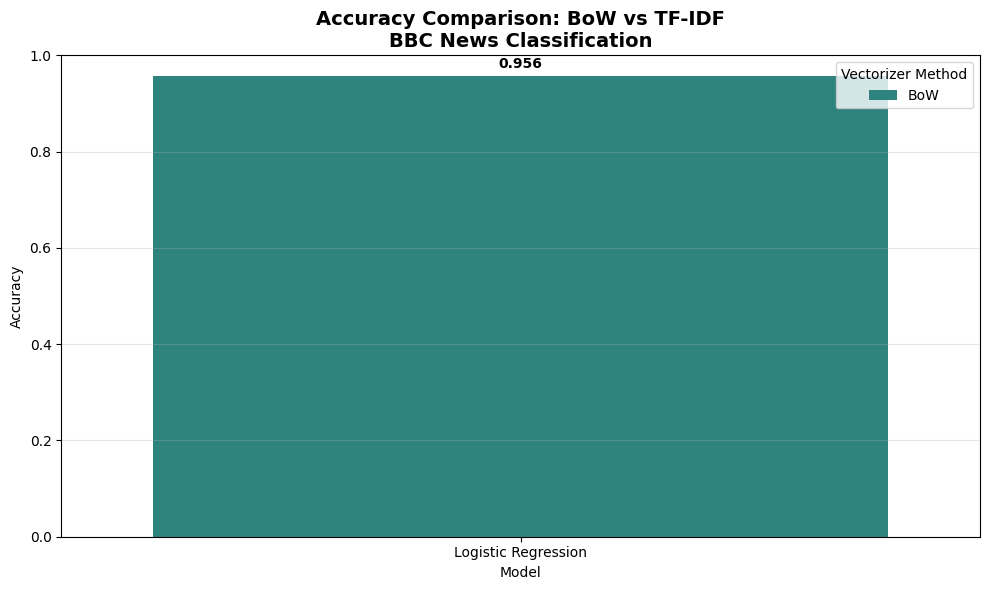

 Accuracy Comparison Table:
              Model Vectorizer  Accuracy
Logistic Regression        BoW  0.956432


In [17]:
# Accuracy Comparison Visualization
if results:
    # Prepare data for comparison
    comparison_data = []
    for key, value in results.items():
        model, vectorizer = key.split('_')
        comparison_data.append({
            'Model': model,
            'Vectorizer': vectorizer,
            'Accuracy': value['accuracy']
        })

    comparison_df = pd.DataFrame(comparison_data)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=comparison_df, x='Model', y='Accuracy', hue='Vectorizer', palette='viridis')
    plt.title('Accuracy Comparison: BoW vs TF-IDF\nBBC News Classification', fontsize=14, fontweight='bold')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.0)
    plt.legend(title='Vectorizer Method')
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, (index, row) in enumerate(comparison_df.iterrows()):
        plt.text(i, row['Accuracy'] + 0.01, f"{row['Accuracy']:.3f}", 
                ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

    print(" Accuracy Comparison Table:")
    print(comparison_df.to_string(index=False))
    
else:
    print(" No results to display")

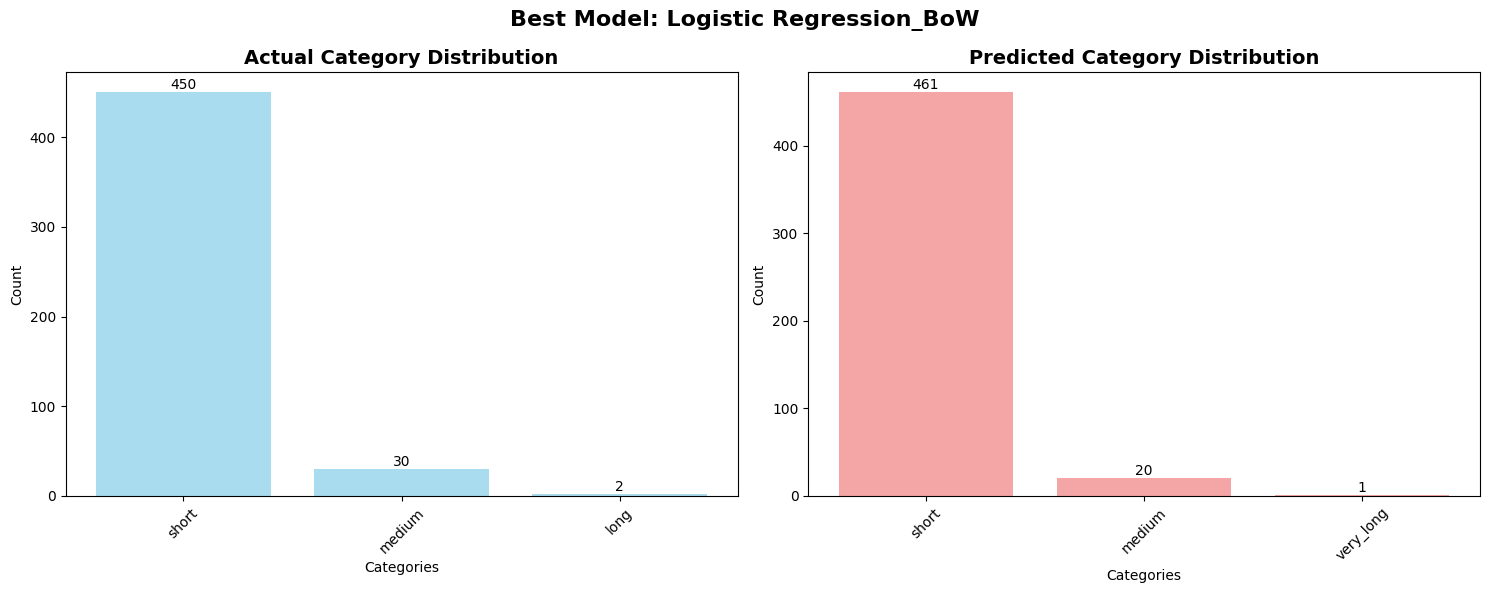

In [19]:
# Distribution of Predicted Categories
if results:
    # Get best model
    best_model_key = max(results.keys(), key=lambda x: results[x]['accuracy'])
    best_predictions = results[best_model_key]['predictions']

    # Convert predictions back to category names
    predicted_categories = label_encoder.inverse_transform(best_predictions)
    actual_categories = label_encoder.inverse_transform(y_test)

    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Actual distribution
    actual_counts = pd.Series(actual_categories).value_counts()
    bars1 = ax1.bar(actual_counts.index, actual_counts.values, color='skyblue', alpha=0.7)
    ax1.set_title('Actual Category Distribution', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Categories')
    ax1.set_ylabel('Count')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add count labels on bars
    for bar, count in zip(bars1, actual_counts.values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                f'{count}', ha='center', va='bottom')

    # Predicted distribution
    predicted_counts = pd.Series(predicted_categories).value_counts()
    bars2 = ax2.bar(predicted_counts.index, predicted_counts.values, color='lightcoral', alpha=0.7)
    ax2.set_title('Predicted Category Distribution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Categories')
    ax2.set_ylabel('Count')
    ax2.tick_params(axis='x', rotation=45)
    
    # Add count labels on bars
    for bar, count in zip(bars2, predicted_counts.values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                f'{count}', ha='center', va='bottom')

    plt.suptitle(f'Best Model: {best_model_key}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

else:
    print(" No results to display")

In [23]:
# Final Results Summary
print("="*70)
print(" FINAL RESULTS SUMMARY - BBC NEWS CLASSIFICATION")
print("="*70)

if results:
    # Results table
    results_summary = []
    for key, value in results.items():
        model, vectorizer = key.split('_')
        results_summary.append({
            'Model': model,
            'Vectorizer': vectorizer,
            'Accuracy': f"{value['accuracy']:.4f}"
        })

    results_df = pd.DataFrame(results_summary)
    print(results_df.to_string(index=False))

    # Best model
    best_result = max(results.items(), key=lambda x: x[1]['accuracy'])
    print(f"\n Best performing model: {best_result[0]}")
    print(f" Best accuracy: {best_result[1]['accuracy']:.4f}")
    
    # Additional metrics
    print(f"\n Dataset Statistics:")
    print(f"   Total articles: {len(df)}")
    print(f"   Number of categories: {len(label_encoder.classes_)}")
    print(f"   Categories: {list(label_encoder.classes_)}")
       
else:
    print(" No results available")



 FINAL RESULTS SUMMARY - BBC NEWS CLASSIFICATION
              Model Vectorizer Accuracy
Logistic Regression        BoW   0.9564

 Best performing model: Logistic Regression_BoW
 Best accuracy: 0.9564

 Dataset Statistics:
   Total articles: 2408
   Number of categories: 4
   Categories: ['long', 'medium', 'short', 'very_long']
